# **ALL**

In [1]:
import numpy as np
import mne
import pandas as pd
import mne_bids
import matplotlib.pyplot as plt

In [2]:
# for speech processing
import WaveGlow_functions
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
import torch
import datetime
import gc
import os
import pickle
import sys
import argparse
from datetime import datetime, timedelta
from subprocess import call, check_output, run
import matplotlib.pyplot as plt
import mne
import numpy as np
import scipy
import librosa
import scipy.signal
import scipy.stats
import scipy.io.wavfile
import scipy.fftpack
import scipy.io as sio
import skimage.transform
import soundfile as sf
import tensorflow as tf

2023-05-20 11:00:32.983748: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-20 11:00:33.756068: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-05-20 11:00:33.756201: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras

In [3]:
# do not use all GPU memory
from tensorflow.compat.v1.keras.backend import set_session
import tensorflow.compat.v1 as tf
config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.3
config.gpu_options.allow_growth = True 
sess = tf.Session(config=config)
set_session(sess)

2023-05-20 11:00:34.669591: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-20 11:00:34.808368: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-20 11:00:34.819023: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-20 11:00:34.819356: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_nod

In [4]:
import scipy
import scipy.io
# import scipy.io.wavfile
import scipy.io.wavfile as io_wav

### **Helper functions**

In [5]:
#Small helper function to speed up the hilbert transform by extending the length of data to the next power of 2
hilbert3 = lambda x: scipy.signal.hilbert(x, scipy.fftpack.next_fast_len(len(x)),axis=0)[:len(x)]

In [6]:
def extractHG(data, sr, windowLength=0.05, frameshift=0.01, bandpass_min=70, bandpass_max=170):
    """
    Window data and extract frequency-band envelope using the hilbert transform
    
    Parameters
    ----------
    data: array (samples, channels)
        EEG time series
    sr: int
        Sampling rate of the data
    windowLength: float
        Length of window (in seconds) in which spectrogram will be calculated
    frameshift: float
        Shift (in seconds) after which next window will be extracted
    Returns
    ----------
    feat: array (windows, channels)
        Frequency-band feature matrix
    """
    #Linear detrend
    data = scipy.signal.detrend(data,axis=0)
    #Number of windows
    numWindows = int(np.floor((data.shape[0]-windowLength*sr)/(frameshift*sr)))
    #Filter High-Gamma Band
    # sos = scipy.signal.iirfilter(4, [70/(sr/2),170/(sr/2)],btype='bandpass',output='sos')
    sos = scipy.signal.iirfilter(4, [bandpass_min/(sr/2),bandpass_max/(sr/2)],btype='bandpass',output='sos')
    data = scipy.signal.sosfiltfilt(sos,data,axis=0)
    #Attenuate first harmonic of line noise
    # sos = scipy.signal.iirfilter(4, [98/(sr/2),102/(sr/2)],btype='bandstop',output='sos')
    # data = scipy.signal.sosfiltfilt(sos,data,axis=0)
    #Attenuate second harmonic of line noise
    # sos = scipy.signal.iirfilter(4, [148/(sr/2),152/(sr/2)],btype='bandstop',output='sos')
    # data = scipy.signal.sosfiltfilt(sos,data,axis=0)
    #Create feature space
    data = np.abs(hilbert3(data))
    feat = np.zeros((numWindows,data.shape[1]))
    for win in range(numWindows):
        start= int(np.floor((win*frameshift)*sr))
        stop = int(np.floor(start+windowLength*sr))
        feat[win,:] = np.mean(data[start:stop,:],axis=0)
    return feat

In [7]:
def stackFeatures(features, modelOrder=4, stepSize=5):
    """
    Add temporal context to each window by stacking neighboring feature vectors
    
    Parameters
    ----------
    features: array (windows, channels)
        Feature time series
    modelOrder: int
        Number of temporal context to include prior to and after current window
    stepSize: float
        Number of temporal context to skip for each next context (to compensate for frameshift)
    Returns
    ----------
    featStacked: array (windows, feat*(2*modelOrder+1))
        Stacked feature matrix
    """
    featStacked=np.zeros((features.shape[0]-(2*modelOrder*stepSize),(2*modelOrder+1)*features.shape[1]))
    for fNum,i in enumerate(range(modelOrder*stepSize,features.shape[0]-modelOrder*stepSize)):
        ef=features[i-modelOrder*stepSize:i+modelOrder*stepSize+1:stepSize,:]
        featStacked[fNum,:]=ef.flatten() #Add 'F' if stacked the same as matlab
    return featStacked

In [8]:
# WaveGlow / Tacotron2 / STFT parameters for audio data
# samplingFrequency = 16000
samplingFrequency = 22050
#samplingFrequency_EEG = 512 #sub 07
winL_EEG = 0.05
# frameshift_EEG = 0.01 # 10 ms
frameshift_EEG = 0.01 # 10 ms
frameshift_speech = 220 # 10ms
# modelOrder_EEG = 1
# modelOrder_EEG = 2
modelOrder_EEG = 4
# modelOrder_EEG = 10
stepSize_EEG = 5

In [9]:
stft = WaveGlow_functions.TacotronSTFT(
        filter_length=1024,
        hop_length=frameshift_speech,
        win_length=1024,
        n_mel_channels=80,
        sampling_rate=samplingFrequency,
        mel_fmin=0,
        mel_fmax=8000)

/environment/notebooks/speech2brain2speech/WaveGlow_functions.py:136: FutureWarning: Pass size=1024 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  fft_window = pad_center(fft_window, filter_length)
/environment/notebooks/speech2brain2speech/WaveGlow_functions.py:222: FutureWarning: Pass sr=22050, n_fft=1024, n_mels=80, fmin=0, fmax=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_basis = librosa_mel_fn(


### **Load Data**

In [10]:
pip install pydub

Note: you may need to restart the kernel to use updated packages.


In [11]:
from pydub import AudioSegment

# Load Audio
wavfile = 'data/stimuli/6min.wav'
audio = AudioSegment.from_file(wavfile, format='wav')

# Shift audio by 150 ms
shifted_audio = audio._spawn(audio.raw_data, overrides={'frame_rate': audio.frame_rate, 'frame_width': audio.sample_width})
shifted_audio = shifted_audio._spawn(shifted_audio.raw_data, overrides={'frame_rate': shifted_audio.frame_rate + int(22050*0.15)})
shifted_audio = shifted_audio.set_frame_rate(audio.frame_rate)
shifted_audio = shifted_audio.set_channels(audio.channels)

# Export shifted audio as WAV file
shifted_audio.export('shifted_audio.wav', format='wav')

/usr/local/lib/python3.8/dist-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


<_io.BufferedRandom name='shifted_audio.wav'>

In [12]:
#Load Audio
wavfile = 'shifted_audio.wav'
mel_data = WaveGlow_functions.get_mel(wavfile, stft)
mel_data = np.fliplr(np.rot90(mel_data.data.numpy(), axes=(1, 0)))

In [13]:

# Print out the duration of the original and shifted audio
print("Original audio duration:", audio.duration_seconds)
print("Shifted audio duration:", shifted_audio.duration_seconds)


Original audio duration: 390.5706666666667
Shifted audio duration: 365.396375


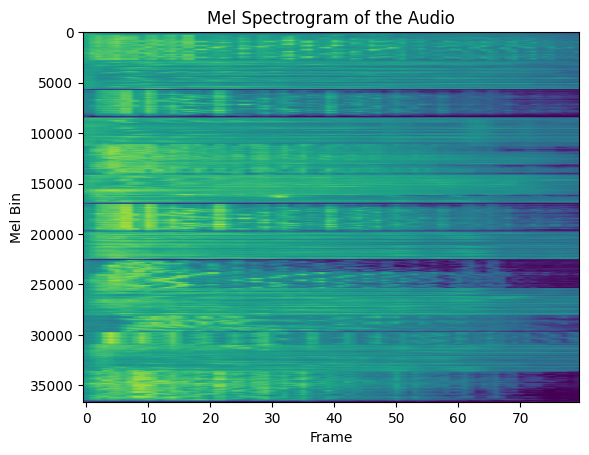

In [14]:
plt.imshow(mel_data, aspect='auto')
plt.xlabel('Frame')
plt.ylabel('Mel Bin')
plt.title('Mel Spectrogram of the Audio')
plt.show()

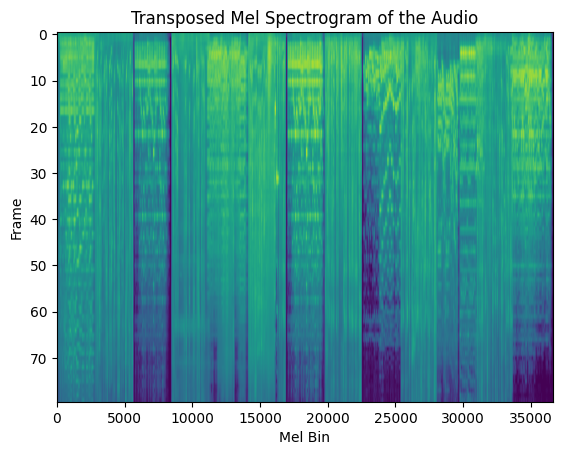

In [15]:
plt.imshow(np.transpose(mel_data), aspect='auto')
plt.xlabel('Mel Bin')
plt.ylabel('Frame')
plt.title('Transposed Mel Spectrogram of the Audio')
plt.show()


In [16]:
#Load Subjects
bids_dir = 'data'
subjects = mne_bids.get_entity_vals(bids_dir, 'subject')
print(subjects)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63']


In [17]:
#Choose subjects
subject = '43'
acquisition = 'clinical'
task = 'film'
datatype = 'ieeg'
session = 'iemu'

In [18]:
#load subject's channels
channels_path = mne_bids.BIDSPath(subject=subject,
                                    session=session,
                                    suffix='channels',
                                    extension='tsv',
                                    datatype=datatype,
                                    task=task,
                                    acquisition=acquisition,
                                    root=bids_dir)

/tmp/ipykernel_62/705515975.py:2: FutureWarning: extension should start with a period ".", but got: "tsv". Prepending "." to form: ".tsv". This will raise an exception starting with MNE-BIDS 0.12.
  channels_path = mne_bids.BIDSPath(subject=subject,


In [19]:
channels = pd.read_csv(str(channels_path.match()[0]), sep='\t', header=0, index_col=None)
#print(channels)

In [20]:
#set channel types
data_path = mne_bids.BIDSPath(subject=subject,
                                    session=session,
                                    suffix='ieeg',
                                    extension='vhdr',
                                    datatype=datatype,
                                    task=task,
                                    acquisition=acquisition,
                                    root=bids_dir)
raw = mne.io.read_raw_brainvision(str(data_path.match()[0]), scale=1.0, preload=False, verbose=True)
raw.set_channel_types({ch_name: str(x).lower()
                if str(x).lower() in ['ecog', 'seeg', 'eeg'] else 'misc'
                                for ch_name, x in zip(raw.ch_names, channels['type'].values)})
raw.drop_channels([raw.ch_names[i] for i, j in enumerate(raw.get_channel_types()) if j == 'misc'])

/tmp/ipykernel_62/3732428725.py:2: FutureWarning: extension should start with a period ".", but got: "vhdr". Prepending "." to form: ".vhdr". This will raise an exception starting with MNE-BIDS 0.12.
  data_path = mne_bids.BIDSPath(subject=subject,


Extracting parameters from data/sub-43/ses-iemu/ieeg/sub-43_ses-iemu_task-film_acq-clinical_run-1_ieeg.vhdr...
Setting channel info structure...


/tmp/ipykernel_62/3732428725.py:11: RuntimeWarning: The unit for channel(s) ECG+, EMG1+, EMG2+, R1+, R2+ has changed from V to NA.
  raw.set_channel_types({ch_name: str(x).lower()


<RawBrainVision | sub-43_ses-iemu_task-film_acq-clinical_run-1_ieeg.eeg, 120 x 201198 (393.0 s), ~123 kB, data not loaded>

print(raw)

### Discard Bad Channels

In [21]:
#bad channels
bad_channels = channels['name'][(channels['type'].isin(['ECOG', 'SEEG'])) & (channels['status'] == 'bad')].tolist()
raw.info['bads'].extend([ch for ch in bad_channels])
raw.drop_channels(raw.info['bads'])

<RawBrainVision | sub-43_ses-iemu_task-film_acq-clinical_run-1_ieeg.eeg, 116 x 201198 (393.0 s), ~119 kB, data not loaded>

### Load Raw Data

In [22]:
raw.load_data()

Reading 0 ... 201197  =      0.000 ...   392.963 secs...


<RawBrainVision | sub-43_ses-iemu_task-film_acq-clinical_run-1_ieeg.eeg, 116 x 201198 (393.0 s), ~178.2 MB, data loaded>

In [23]:
n_eeg_channels = int(raw.info['nchan']) # for subject 01
print('n_eeg_channels', n_eeg_channels)
# raise

n_eeg_channels 116


### Apply notch filter to remove line noise

In [24]:
raw.notch_filter(freqs=np.arange(50, 251, 50))

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 116 out of 116 | elapsed:    0.5s finished


<RawBrainVision | sub-43_ses-iemu_task-film_acq-clinical_run-1_ieeg.eeg, 116 x 201198 (393.0 s), ~178.2 MB, data loaded>

raw.plot()
plt.show()

### Apply common average reference to remove common noise and trends

In [25]:
#CAR
raw_car, _ = mne.set_eeg_reference(raw.copy(), 'average')

ECoG channel type selected for re-referencing
Applying average reference.
Applying a custom ('ECoG',) reference.


In [26]:
gamma = raw_car.copy().filter(60, 120).apply_hilbert(envelope=True).get_data()#.T
print('raw_car.shape:', raw_car._data.shape, 'gamma shape: ', gamma.shape)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 60 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 60.00
- Lower transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 52.50 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 113 samples (0.221 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 116 out of 116 | elapsed:    0.9s finished


raw_car.shape: (116, 201198) gamma shape:  (116, 201198)


#Extract signal in gamma range, use Hilbert transform, but can also play around with wavelet decomposition options


gamma = raw_car.copy().filter(60, 120).apply_hilbert(envelope=True).get_data().T

### Read annotation with event markers

In [27]:
custom_mapping = {'Stimulus/music': 2, 'Stimulus/speech': 1,
                  'Stimulus/end task': 5}  # 'Stimulus/task end' in laan
events, event_id = mne.events_from_annotations(raw_car, event_id=custom_mapping,
                                                         use_rounding=False)

Used Annotations descriptions: ['Stimulus/end task', 'Stimulus/music', 'Stimulus/speech']


Using matplotlib as 2D backend.


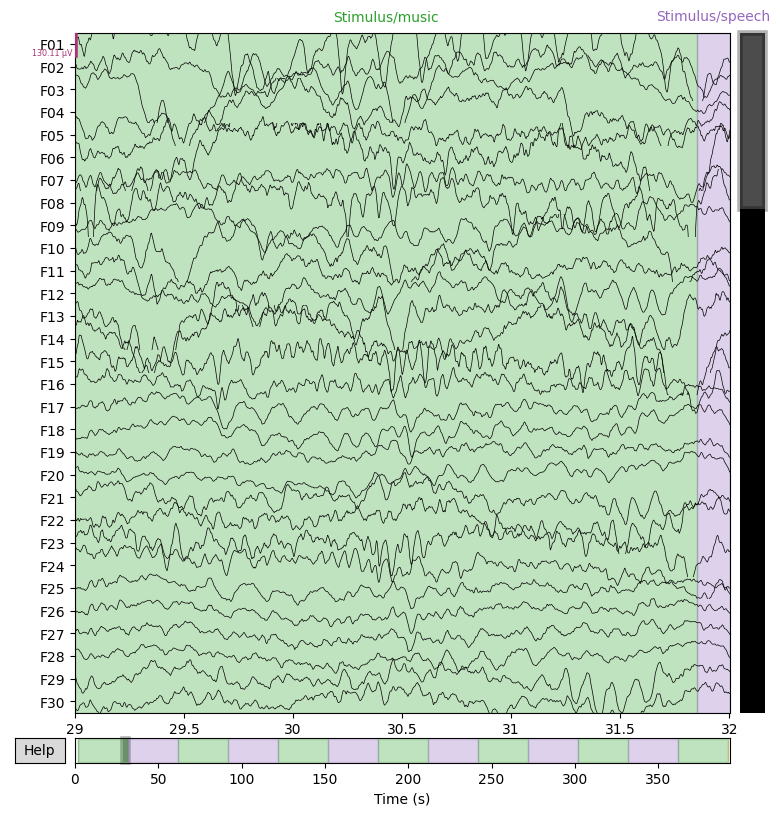

In [28]:
#plotting
raw_car.plot(n_channels=30,scalings='auto', duration=3, start=29)
plt.show()

In [29]:
# assume gamma is a 2D array
np.savetxt("gamma.tsv", gamma, delimiter="\t")

In [30]:
event_id

{'Stimulus/end task': 5, 'Stimulus/music': 2, 'Stimulus/speech': 1}

raise

In [31]:
print(events)

[[   957      0      2]
 [ 16309      0      1]
 [ 31669      0      2]
 [ 47029      0      1]
 [ 62389      0      2]
 [ 77754      0      1]
 [ 93109      0      2]
 [108469      0      1]
 [123829      0      2]
 [139190      0      1]
 [154553      0      2]
 [169909      0      1]
 [185269      0      2]
 [200639      0      5]]


In [ ]:
#viz

In [32]:
import numpy as np
import mne
import pandas as pd
import os
import mne_bids
import nibabel


mne.viz.set_3d_backend('notebook')
%matplotlib inline

Using notebook 3d backend.



In [35]:
montage = mne.channels.make_dig_montage(ch_pos=dict(zip(channels['name'], channels[['x', 'y', 'z']].values)))


KeyError: "None of [Index(['x', 'y', 'z'], dtype='object')] are in the [columns]"

In [33]:
from packaging import version

if version.parse(mne.__version__) <= version.parse('0.22.0'):
    fig = mne.viz.plot_alignment(raw.info,
                   subject='sub-' + subject,
                   subjects_dir=os.path.dirname(fs_dir),
                   surfaces=['pial'],
                   coord_frame='mri')
else:
    # trans argument became mandatory
    identity_trans = mne.transforms.Transform('head', 'mri')
    fig = mne.viz.plot_alignment(raw.info, trans=identity_trans,
               subject='sub-' + subject,
               subjects_dir=os.path.dirname(fs_dir),
               surfaces=['pial'],
               coord_frame='mri')
mne.viz.set_3d_view(fig, 180, 70, distance=.5)

NameError: name 'fs_dir' is not defined

raw_car.plot(events=events, start=0, duration=30, color='gray', event_color={2: 'g', 1: 'r'}, bgcolor='w')
plt.show()

### get channel amount

### autovocoder

In [32]:
n_melspec = 80

In [33]:
#get EEG SR
samplingFrequency_EEG=raw_car.info['sfreq']

### Crop to keep only the segments while wathcing the stimuli ( 6.5 min long movie)

In [34]:
#create a copy taht we crop
raw_car_cut = raw_car._data.copy()
print(raw_car_cut.shape)

(116, 201198)


In [35]:
print('before cut: ', raw_car._data.shape, mel_data.shape)

raw_car_cut = np.empty((n_eeg_channels,0))
mel_data_cut = np.empty((0,n_melspec))


# for i in range(6):
for i in range(6):
    start_time = events[2*i+1, 0] / raw_car.info['sfreq']
    end_time = events[2*i+2, 0] / raw_car.info['sfreq']
    start_idx, end_idx = raw_car.time_as_index([start_time, end_time])
    print(i, 'iEEG index', start_idx, end_idx, end_idx-start_idx)
    n_frames_per_sec = int(1 / frameshift_EEG)
    print(i, 'melspec index', (2*i+1)*30*n_frames_per_sec, (2*i+2)*30*n_frames_per_sec, (2*i+2)*30*n_frames_per_sec-(2*i+1)*30*n_frames_per_sec)
    # raw_car_cut1 = raw_car._data[:, start_idx:end_idx]
    raw_car_cut1 = gamma[:, start_idx:end_idx]
    raw_car_cut = np.append(raw_car_cut, raw_car_cut1, axis=1)
    mel_data_cut1 = mel_data[(2*i+1)*30*n_frames_per_sec : (2*i+2)*30*n_frames_per_sec]
    mel_data_cut = np.append(mel_data_cut, mel_data_cut1, axis=0)
# raise
mel_data = mel_data_cut

print('after cut: ', raw_car_cut.shape, mel_data.shape)
# raise
#praat

before cut:  (116, 201198) (36623, 80)
0 iEEG index 16309 31669 15360
0 melspec index 3000 6000 3000
1 iEEG index 47029 62389 15360
1 melspec index 9000 12000 3000
2 iEEG index 77754 93109 15355
2 melspec index 15000 18000 3000
3 iEEG index 108469 123829 15360
3 melspec index 21000 24000 3000
4 iEEG index 139190 154553 15363
4 melspec index 27000 30000 3000
5 iEEG index 169909 185269 15360
5 melspec index 33000 36000 3000
after cut:  (116, 92158) (18000, 80)


In [36]:
#get EEG SR
samplingFrequency_EEG=raw_car.info['sfreq']

# Calculate the length of the signal
length = raw_car_cut.shape[1] / samplingFrequency_EEG 
print("The length of the EEG signal is", length,"s")
print(samplingFrequency_EEG)

The length of the EEG signal is 179.99609375 s
512.0


crop to first 10 seconds
raw_car_cut = raw_car_cut[:, 0:300*2048]
mel_data = mel_data[0:300*100]

In [37]:
print('before cut: ', raw_car._data.shape, mel_data.shape)

before cut:  (116, 201198) (18000, 80)


### Prepare Data for training

### Extract features

In [38]:
#Extract HG features
print('calculating Hilbert...', raw_car_cut.shape)
# eeg_fft = np.empty((n_max_frames, n_freq_bands, n_eeg_channels * (2 * modelOrder_EEG + 1) ))
# feat_Hilbert_1 = extractHG(raw_car_cut,samplingFrequency_EEG, windowLength=winL_EEG,frameshift=frameshift_EEG, bandpass_min=1, bandpass_max=200)
feat_Hilbert_1 = extractHG(np.rot90(raw_car_cut),samplingFrequency_EEG, windowLength=winL_EEG,frameshift=frameshift_EEG, bandpass_min=1, bandpass_max=200)
# feat_Hilbert_2 = extractHG(np.rot90(current_raw_eeg_data),samplingFrequency_EEG, windowLength=winL_EEG,frameshift=frameshift_EEG, bandpass_min=51, bandpass_max=100)
# feat_Hilbert_3 = extractHG(np.rot90(current_raw_eeg_data),samplingFrequency_EEG, windowLength=winL_EEG,frameshift=frameshift_EEG, bandpass_min=101, bandpass_max=150)
# feat_Hilbert_4 = extractHG(np.rot90(current_raw_eeg_data),samplingFrequency_EEG, windowLength=winL_EEG,frameshift=frameshift_EEG, bandpass_min=151, bandpass_max=200)

calculating Hilbert... (116, 92158)


In [39]:
#Stack features
feat_Hilbert_1 = stackFeatures(feat_Hilbert_1,modelOrder=modelOrder_EEG,stepSize=stepSize_EEG)

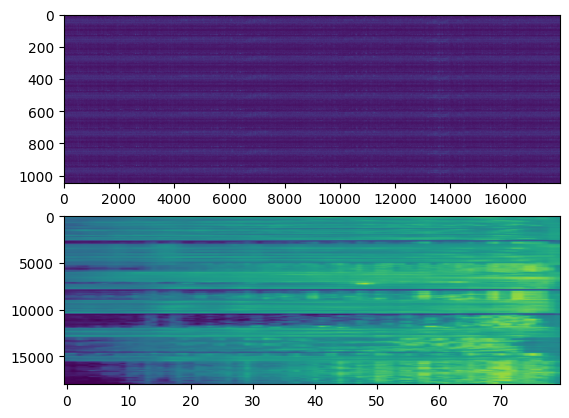

In [40]:

plt.subplot(211)
plt.imshow(np.rot90(feat_Hilbert_1), aspect='auto')

plt.subplot(212)
plt.imshow(np.rot90(mel_data).T, aspect='auto')
plt.show()


eeg = feat_Hilbert_1

In [41]:
min_len = np.min((len(eeg), len(mel_data)))
eeg = eeg[0:min_len]
mel_data = mel_data[0:min_len]

In [42]:
print('mel & iEEG: ', mel_data.shape, feat_Hilbert_1.shape)

mel & iEEG:  (17954, 80) (17954, 1044)


In [43]:
train_index = np.arange(0, int(0.8 * eeg.shape[0]))
test_index = np.arange(int(0.8 * eeg.shape[0]), eeg.shape[0])

In [44]:
# train-validation-test split
eeg_train = eeg[0 : int(len(eeg) * 0.8)]
eeg_valid = eeg[int(len(eeg) * 0.8) : int(len(eeg) * 0.9)]
eeg_test =  eeg[int(len(eeg) * 0.9) : ]    

In [45]:
melspec_train = mel_data[0 : int(len(mel_data) * 0.8)]
melspec_valid = mel_data[int(len(mel_data) * 0.8) : int(len(mel_data) * 0.9)]
melspec_test =  mel_data[int(len(mel_data) * 0.9) : ]    

In [46]:
# scale input to [0-1]
eeg_scaler = MinMaxScaler()
# eeg_scaler = StandardScaler(with_mean=True, with_std=True)
eeg_train_scaled = eeg_scaler.fit_transform(eeg_train)
eeg_valid_scaled = eeg_scaler.transform(eeg_valid)
eeg_test_scaled  = eeg_scaler.transform(eeg_test)

In [47]:
# scale outpit mel-spectrogram data to zero mean, unit variances
melspec_scaler = StandardScaler(with_mean=True, with_std=True)
melspec_train_scaled = melspec_scaler.fit_transform(melspec_train)
melspec_valid_scaled = melspec_scaler.transform(melspec_valid)
melspec_test_scaled  = melspec_scaler.transform(melspec_test)

### FC-DNN

In [48]:
# 5 hidden layers, with 1000 neuron on each layer
model = Sequential()
model.add(
    Dense(
        15000,
        input_dim=eeg_train_scaled.shape[1],
        kernel_initializer='normal',
        activation='relu'))
model.add(
    Dense(
        80,
        kernel_initializer='normal',
        activation='linear'))

2023-05-15 07:02:23.729089: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-15 07:02:23.730012: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-15 07:02:23.730252: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-15 07:02:23.732922: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-15 07:02:23.733227: I tensorflow/compile

In [49]:
# compile model
model.compile(
    loss='mean_squared_error',
    metrics=['mean_squared_error'],
    optimizer='adam')
earlystopper = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0.0001,
    patience=5,
    verbose=1,
    mode='auto')

In [50]:
if not (os.path.isdir('models_iEEG_to_melspec/')):
    os.mkdir('models_iEEG_to_melspec/')

In [51]:
# early stopping to avoid over-training
# csv logger
current_date = '{date:%Y-%m-%d_%H-%M-%S}'.format(
    date=datetime.now())
print(current_date)
# n_eeg_channels * (2 * modelOrder_EEG + 1)
model_name = 'models_iEEG_to_melspec/iEEG-Hilbert_to_melspec_DNN_modelOrder-' + str(modelOrder_EEG).zfill(2) + '_freqBands-1_' + '_sub' + subject + '_' + current_date
logger = CSVLogger(model_name + '.csv', append=True, separator=';')
checkp = ModelCheckpoint(
    model_name +
    '_weights_best.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min')

2023-05-15_07-02-24


serialize scalers to pickle
pickle.dump(eeg_scaler, open(model_name + '_eeg_scaler.sav', 'wb'))
pickle.dump(melspec_scaler, open(model_name + '_melspec_scaler.sav', 'wb'))

### Run training

In [52]:
history = model.fit(eeg_train_scaled, melspec_train_scaled,
                    epochs=50, batch_size=32, shuffle=True, verbose=1,
                    callbacks=[earlystopper, logger, checkp],
                    validation_split = 0.9,
                    validation_data=(eeg_valid_scaled, melspec_valid_scaled),
                    )

Epoch 1/50


2023-05-15 07:02:26.079685: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-15 07:02:26.364221: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f7848410910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-15 07:02:26.364297: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2023-05-15 07:02:26.393399: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-15 07:02:26.695915: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


439/449 [============================>.] - ETA: 0s - loss: 1.3098 - mean_squared_error: 1.3098
Epoch 1: val_loss improved from inf to 0.88959, saving model to models_iEEG_to_melspec/iEEG-Hilbert_to_melspec_DNN_modelOrder-04_freqBands-1__sub43_2023-05-15_07-02-24_weights_best.h5
449/449 [==============================] - 6s 7ms/step - loss: 1.3002 - mean_squared_error: 1.3002 - val_loss: 0.8896 - val_mean_squared_error: 0.8896
Epoch 2/50
440/449 [============================>.] - ETA: 0s - loss: 0.7875 - mean_squared_error: 0.7875
Epoch 2: val_loss did not improve from 0.88959
449/449 [==============================] - 2s 5ms/step - loss: 0.7863 - mean_squared_error: 0.7863 - val_loss: 0.9678 - val_mean_squared_error: 0.9678
Epoch 3/50
442/449 [============================>.] - ETA: 0s - loss: 0.6784 - mean_squared_error: 0.6784
Epoch 3: val_loss did not improve from 0.88959
449/449 [==============================] - 2s 5ms/step - loss: 0.6773 - mean_squared_error: 0.6773 - val_loss: 1.

In [53]:
# save model
model_json = model.to_json()
with open(model_name + '_model.json', "w") as json_file:
    json_file.write(model_json)
    
# here the training of the DNN is finished
# load back best weights
model.load_weights(model_name + '_weights_best.h5')
# remove model file
# os.remove(model_name + '_weights_best.h5')

### Visualize predicted melspectogram

32/32 [==============================] - 0s 1ms/step
Best validation MSE: 0.8896
Minimum training loss: 0.3972


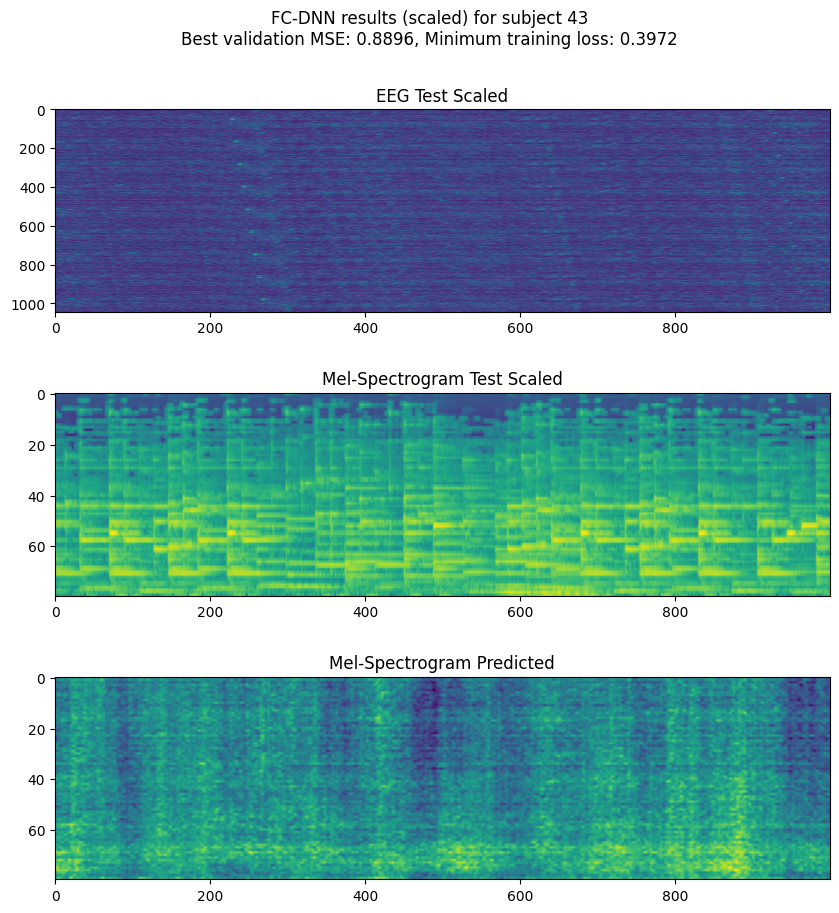

In [54]:
# melspec_predicted = model.predict(eeg_test_scaled[0:500])
melspec_predicted = model.predict(eeg_test_scaled[0:1000])
# melspec_predicted = melspec_predicted[0:500]
# test_melspec = test_melspec[]


#best stuff

best_val_mse = min(history.history['val_mean_squared_error'])
print(f'Best validation MSE: {best_val_mse:.4f}')

min_train_loss = min(history.history['loss'])
print(f'Minimum training loss: {min_train_loss:.4f}')


fig, axs = plt.subplots(3, 1, figsize=(10, 10))
axs[0].imshow(np.rot90(eeg_test_scaled[0:1000]), aspect='auto')
axs[0].set_title('EEG Test Scaled')
axs[1].imshow(np.rot90(melspec_test_scaled[0:1000]), aspect='auto')
axs[1].set_title('Mel-Spectrogram Test Scaled')
axs[2].imshow(np.rot90(melspec_predicted[0:1000]), aspect='auto')
axs[2].set_title('Mel-Spectrogram Predicted')
plt.suptitle(f'FC-DNN results (scaled) for subject {subject}\nBest validation MSE: {best_val_mse:.4f}, Minimum training loss: {min_train_loss:.4f}')
plt.subplots_adjust(hspace=0.4)


plt.savefig(model_name + '_EEG_scaled_plots.png')
plt.show()



ult_predicted = ult_predicted.reshape(-1, NumVectors, PixPerVector_resized)
ult_test = ult_test.reshape(-1, NumVectors, PixPerVector_resized)

In [55]:
plt.savefig(model_name + '_EEG_scaled.png')
plt.show()

<Figure size 640x480 with 0 Axes>

# **Create audio**

In [1]:
import librosa

# Provide the actual mel spectrogram (melspec_predicted) and sampling frequency (samplingFrequency) from your FC-DNN output
samplingFrequency = 512

# Convert mel spectrogram to audio using Griffin-Lim algorithm
audio = librosa.feature.inverse.mel_to_audio(melspec_predicted, sr=samplingFrequency)

# Save the audio to a WAV file
output_file = 'predicted_audio.wav'
sf.write(output_file, audio, samplingFrequency)

NameError: name 'melspec_predicted' is not defined

# **2D CNN**

In [58]:
import os
import numpy as np
import MelFilterBank as mel
import reconstructWave as rW
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, InputLayer, Dropout
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import datetime
from keras.utils.vis_utils import plot_model
import torch
import sys
import soundfile as sf
import skimage.transform
from tensorflow import keras
import gc

In [59]:
def strided_app(a, L, S, verbose=None):  # Window len = L, Stride len/stepsize = S
    shape = a.shape[1:]
    nrows = ((a.shape[0] - L) // S) + 1
    strides = a.strides
    #print(shape, strides)
    if verbose:
        print("strides:", strides)
    return np.lib.stride_tricks.as_strided(a, shape=(nrows, L) + shape,
                                           strides=(S * strides[0],) + strides)

In [60]:
method = '2D-CNN'
result_path = os.path.join(os.getcwd(), f"results_{method}")
winLength = 0.05
frameshift = 0.01
audiosr = 16000

spectrogram = mel_data
data = eeg
pt=subject

In [61]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


Physical devices cannot be modified after being initialized


In [62]:
    # Create a train and test split from data, test is 20% of the data
    train_index = np.arange(0, int(0.8 * data.shape[0]))
    test_index = np.arange(int(0.8 * data.shape[0]), data.shape[0])

    # Initialize an empty spectrogram to save the reconstruction to
    rec_spec = np.zeros(spectrogram.shape)

    # Z-Normalize with mean and std from the training data
    mu = np.mean(data[train_index, :], axis=0)
    std = np.std(data[train_index, :], axis=0)
    trainData = (data[train_index, :] - mu) / std
    testData = (data[test_index, :] - mu) / std

    # Z-Normalize with mean and std from the training data -- output
    mu = np.mean(spectrogram[train_index, :], axis=0)
    std = np.std(spectrogram[train_index, :], axis=0)
    trainSpectrogram = (spectrogram[train_index, :] - mu) / std
    testSpectrogram = (spectrogram[test_index, :] - mu) / std

    print('Input shape: ', trainData.shape)
    print('Input shape: ', testData.shape)
        
    # Find the right shape for the input, as it should be 3D, like 1143 is 9*127
    new_shape = int(trainData.shape[1] / 9)

    # reshape input from 1143 to 9*127
    trainData = trainData.reshape(-1, 9, new_shape)
    testData = testData.reshape(-1, 9, new_shape)
    print('Input shape: ', trainData.shape)

    sts = 6
    window_size = sts * 4 + 1
    n_to_skip = np.floor(window_size // 2).astype(np.int64)

    print('Input shape: ', trainData.shape)

    #conversion to 3D blocks
    trainData = strided_app(trainData, window_size, 1)
    trainSpectrogram = trainSpectrogram[n_to_skip:(trainSpectrogram.shape[0] - n_to_skip)]

    testData = strided_app(testData, window_size, 1)
    testSpectrogram = testSpectrogram[n_to_skip:(testSpectrogram.shape[0] - n_to_skip)]

    print('Input shape: ', trainData.shape)
    print('Input/validation shape: ', testData.shape)
    print('Output shape: ', trainSpectrogram.shape)

Input shape:  (14363, 1044)
Input shape:  (3591, 1044)
Input shape:  (14363, 9, 116)
Input shape:  (14363, 9, 116)
Input shape:  (14339, 25, 9, 116)
Input/validation shape:  (3567, 25, 9, 116)
Output shape:  (14339, 80)


In [ ]:
    model = Sequential()
    model.add(InputLayer(input_shape=trainData.shape[1:]))
    model.add(Conv2D(filters=40,
                     kernel_size=(13, 13),
                     strides=(sts, 2),
                     activation=tensorflow.nn.swish,
                     padding="same",
                     kernel_initializer=keras.initializers.he_uniform(seed=None),
                     kernel_regularizer=regularizers.l1(0.00001),
                     input_shape=trainData.shape[1:]))

    model.add(Dropout(0.1))
    model.add(Conv2D(filters=60, kernel_size=(13, 13), strides=(2, 2), activation=tensorflow.nn.swish,
                     padding="same", kernel_initializer=keras.initializers.he_uniform(seed=None),
                     kernel_regularizer=regularizers.l1(0.00001)))
    model.add(Dropout(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=100, kernel_size=(13, 13), strides=(2, 2), activation=tensorflow.nn.swish,
                     padding="same", kernel_initializer=keras.initializers.he_uniform(seed=None),
                     kernel_regularizer=regularizers.l1(0.00001)))
    model.add(Dropout(0.1))
    # model.add(Conv3D(filters=58, kernel_size=(1, 13, 13), strides=(1, 1, 1), activation=tensorflow.nn.swish,
                     # padding="same", kernel_initializer=keras.initializers.he_uniform(seed=None),
                     # kernel_regularizer=regularizers.l1(0.00001)))
    # model.add(Dropout(0.2))
    # model.add(MaxPooling3D(pool_size=(1, 2, 2)))
    model.add(Flatten())
    model.add(
        Dense(2000, activation=tensorflow.nn.swish, kernel_initializer=keras.initializers.he_uniform(seed=None),
              bias_initializer=keras.initializers.he_uniform(seed=None),
              kernel_regularizer=regularizers.l1(0.000005)))
    model.add(Dropout(0.1))
    model.add(Dense(trainSpectrogram.shape[1], activation='linear'))

    plot_model(model, to_file=f"model_{method}.png", show_shapes=True, show_layer_names=True)

    model.compile(
            loss='mean_squared_error',
            metrics=['mean_squared_error'],
            optimizer='adam')
    earlystopper = EarlyStopping(monitor='val_mean_squared_error', min_delta=0.0001, patience=3, verbose=1,
                                 mode='auto')
    lrr = ReduceLROnPlateau(monitor='val_mean_squared_error', patience=2, verbose=1, factor=0.5, min_lr=0.0001)

    print(model.summary())

    if not (os.path.isdir('models/')):
        os.mkdir('models/')

    # early stopping to avoid over-training
    model_name = 'models/iEEG_to_melspec_2D-CNN_sp-' + pt

    # csapot: temporarily disabled
    checkp = ModelCheckpoint(
        model_name +
        '_weights_best.h5',
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        mode='min')

    # Run training
    history = model.fit(trainData, trainSpectrogram,
                        epochs=100, batch_size=64, shuffle=False, verbose=1,
                        callbacks=[earlystopper, checkp, lrr],
                        validation_data=(testData, testSpectrogram),
                        )


    # load back best weights
    model.load_weights(model_name + '_weights_best.h5')

    rec_spec = model.predict(testData)

    # inverse transform
    # testSpectrogram=(spectrogram[test,:]-mu)/std
    rec_spec = rec_spec * std + mu

    print('start saving wav')

    # Save reconstructed spectrogram
    os.makedirs(os.path.join(result_path), exist_ok=True)
    np.save(os.path.join(result_path, f'{pt}_predicted_spec.npy'), rec_spec)


    # remove model file
    os.remove(model_name + '_weights_best.h5')
    del model
    # Run garbage collection
    gc.collect()
    
    

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 5, 5, 40)          784200    
                                                                 
 dropout (Dropout)           (None, 5, 5, 40)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 60)          405660    
                                                                 
 dropout_1 (Dropout)         (None, 3, 3, 60)          0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 1, 60)         0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 100)         1014100   
                                                      

2023-05-15 07:02:45.536400: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1496991600 exceeds 10% of free system memory.
2023-05-15 07:02:46.733283: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1496991600 exceeds 10% of free system memory.


Epoch 1/100


2023-05-15 07:02:47.927500: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-05-15 07:02:48.582189: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8500


225/225 [==============================] - ETA: 0s - loss: 1.2237 - mean_squared_error: 0.9981

2023-05-15 07:02:54.199046: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 372394800 exceeds 10% of free system memory.
2023-05-15 07:02:54.648953: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 372394800 exceeds 10% of free system memory.



Epoch 1: val_loss improved from inf to 1.06478, saving model to models/iEEG_to_melspec_2D-CNN_sp-43_weights_best.h5
225/225 [==============================] - 8s 18ms/step - loss: 1.2237 - mean_squared_error: 0.9981 - val_loss: 1.0648 - val_mean_squared_error: 0.8312 - lr: 0.0010
Epoch 2/100
225/225 [==============================] - ETA: 0s - loss: 1.1849 - mean_squared_error: 0.9592
Epoch 2: val_loss did not improve from 1.06478
225/225 [==============================] - 2s 11ms/step - loss: 1.1849 - mean_squared_error: 0.9592 - val_loss: 1.1046 - val_mean_squared_error: 0.8785 - lr: 0.0010
Epoch 3/100
225/225 [==============================] - ETA: 0s - loss: 1.1701 - mean_squared_error: 0.9450
Epoch 3: val_loss improved from 1.06478 to 1.05697, saving model to models/iEEG_to_melspec_2D-CNN_sp-43_weights_best.h5
225/225 [==============================] - 2s 11ms/step - loss: 1.1701 - mean_squared_error: 0.9450 - val_loss: 1.0570 - val_mean_squared_error: 0.8265 - lr: 0.0010
Epoch 4

In [ ]:

best_val_mse = min(history.history['val_mean_squared_error'])
print(f'Best validation MSE: {best_val_mse:.4f}')

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

axs[0].imshow(np.rot90(melspec_test_scaled[0:1000]), aspect='auto')
axs[0].set_title('EEG Test Scaled')

axs[1].imshow(np.rot90(melspec_predicted[0:1000]), aspect='auto')
axs[1].set_title('FC-DNN')

axs[2].imshow(np.rot90(rec_spec[0:1000]), aspect='auto')
axs[2].set_title('2D-CNN')

plt.subplots_adjust(hspace=0.4)
plt.suptitle('FC-DNN vs 2D-CNN results for patient ' + subject + ' ' + f'Best validation MSE: {best_val_mse:.4f}')
plt.savefig(model_name + '_EEG_scaled_plots.png')
plt.show()